<div style="background-color: #B3FFDD; padding: 20px; margin: 20px; font-family: 'Arial', sans-serif; border-radius:10px;">
  <h1 style="font-family: 'Courier New', monospace;">🏠 Brooklyn House Prices Prediction 💰</h1>
  <p>💥 The real estate market in New York City is heating up, and it's becoming increasingly challenging for homebuyers to predict the market value of properties. 💰</p>
    <p>📈 Brooklyn, one of the five boroughs of New York City, has seen a significant rise in real estate prices in recent years. The increase in demand for housing in Brooklyn has made it difficult for homebuyers to predict the market value of properties. This has resulted in a need for a reliable tool that can accurately predict the price of homes in Brooklyn. <p>
  <p>Our goal is to provide a solution to this problem by building a machine learning model that can accurately predict the sale price of a house.. 🤖</p>
  <p>The outcome of this project will be a useful tool for homebuyers, sellers, and real estate agents to make informed decisions about buying and selling homes in Brooklyn. 💡</p>
</div>"

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error

import joblib

In [4]:
plt.style.use('tableau-colorblind10')
sns.set_style('whitegrid')

# Import the datasets

In [5]:
df = pd.read_csv('/kaggle/input/brooklynhomes2003to2017/brooklyn_sales_map.csv', index_col=[0])
df.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (40,41,43,45,46,47,86) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,borough,neighborhood,building_class_category,tax_class,block,lot,easement,building_class,address,apartment_number,...,EDesigNum,APPBBL,APPDate,PLUTOMapID,FIRM07_FLA,PFIRM15_FL,Version,MAPPLUTO_F,SHAPE_Leng,SHAPE_Area
1,3,DOWNTOWN-METROTECH,28 COMMERCIAL CONDOS,4,140,1001,NaN,R5,330 JAY STREET,COURT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,DOWNTOWN-FULTON FERRY,29 COMMERCIAL GARAGES,4,54,1,NaN,G7,85 JAY STREET,NaN,...,NaN,3.000540e+09,12/06/2002,1.0,NaN,NaN,17V1.1,0.0,1559.889144,140131.577176
3,3,BROOKLYN HEIGHTS,21 OFFICE BUILDINGS,4,204,1,NaN,O6,29 COLUMBIA HEIGHTS,NaN,...,NaN,0.000000e+00,NaN,1.0,NaN,NaN,17V1.1,0.0,890.718521,34656.447240
4,3,MILL BASIN,22 STORE BUILDINGS,4,8470,55,NaN,K6,5120 AVENUE U,NaN,...,NaN,0.000000e+00,NaN,1.0,1.0,1.0,17V1.1,0.0,3729.786857,797554.847834
5,3,BROOKLYN HEIGHTS,26 OTHER HOTELS,4,230,1,NaN,H8,21 CLARK STREET,NaN,...,NaN,0.000000e+00,NaN,1.0,NaN,NaN,17V1.1,0.0,620.761169,21360.147631


In [8]:
df['sale_price'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.997, 1])

0.000            0.0
0.250            0.0
0.500       275000.0
0.750       593000.0
0.900       965000.0
0.950      1445000.0
0.990      4075000.0
0.997     10250000.0
1.000    499401179.0
Name: sale_price, dtype: float64

In [9]:
df['year_built'].quantile([0, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.997, 1])

0.000       0.0
0.250    1905.0
0.500    1925.0
0.750    1954.0
0.900    2004.0
0.950    2007.0
0.990    2013.0
0.997    2015.0
1.000    2017.0
Name: year_built, dtype: float64

<div style="background-color: #f2f2f2; padding: 1em; border-radius: 0.5em; margin: 1em; font-family: Arial, sans-serif; font-size: 14px; font-style: italic;">
    <p>
💥The analysis of the house prices in Brooklyn reveals that the range extends from a mere $0 to a staggering $499 Million! </p><p>🤯However, the skewed distribution of the target variable to the right can be attributed to the presence of a limited number of data points.🧐</p><p>
👀It's worth noting that the "year_built" column has numerous values dating back before 1905. In order to combat the skewed distribution of the target variable and ensure accurate predictions, it's recommended that we eliminate data points whose prices are not within the range of $100,000  and  $10,000,000 and also homes built prior to 1900.💡
</p>
</div>

In [185]:
mask = (df['year_built'] > 1900) & (df['sale_price'] > 100000) & (df['sale_price'] < 1e7)
df = df[mask]

In [186]:
df.shape

(197492, 110)

# Feature Selection and Feature Engineering

<div style="background-color: #f2f2f2; padding: 1em; border-radius: 0.5em; margin: 1em; font-family: Arial, sans-serif; font-size: 14px; font-style: italic;">
  🧐 It appears that there are a substantial amount of missing values in a majority of the columns. To address this issue, I've established a 50% missing value cutoff. Columns that exceed this threshold will be removed.
</div>

In [187]:
req_cols = []

for col in df.columns:
    is_na = round(df[col].isna().sum() / len(df) * 100, 2)
    if is_na < 50:
        req_cols.append(col)
    print(f"{col} has {is_na} % of nan values")

print(f"{len(req_cols)} has less than 50% of nan values")
df = df[req_cols]
print(df.shape)

borough has 0.0 % of nan values
neighborhood has 0.0 % of nan values
building_class_category has 0.01 % of nan values
tax_class has 0.0 % of nan values
block has 0.0 % of nan values
lot has 0.0 % of nan values
easement has 100.0 % of nan values
building_class has 0.0 % of nan values
address has 0.0 % of nan values
apartment_number has 81.97 % of nan values
zip_code has 0.0 % of nan values
residential_units has 0.0 % of nan values
commercial_units has 0.0 % of nan values
total_units has 0.0 % of nan values
land_sqft has 0.0 % of nan values
gross_sqft has 0.0 % of nan values
year_built has 0.0 % of nan values
tax_class_at_sale has 0.0 % of nan values
building_class_at_sale has 0.0 % of nan values
sale_price has 0.0 % of nan values
sale_date has 0.0 % of nan values
year_of_sale has 0.0 % of nan values
Borough has 16.08 % of nan values
CD has 16.08 % of nan values
CT2010 has 16.08 % of nan values
CB2010 has 16.09 % of nan values
SchoolDist has 16.08 % of nan values
Council has 16.08 % of n

### Categorical Columns

<div style="background-color: #f2f2f2; padding: 1em; border-radius: 0.5em; margin: 1em; font-style: italic;">
  <p><span style="color: #339966;">💡</span> Another issue we face is cardinality in our categorical data. High cardinality columns, with a large number of categories, can increase the complexity of our model. To mitigate this, we will be dropping high cardinality columns, with the exception of Neighborhood and Building Class. These two columns have a high potential impact on our target variable and will be retained. To further reduce the cardinality of these columns, we'll need to consider appropriate strategies, such as grouping the minority categories together. </p>
</div>

In [188]:
cat_cols = df.select_dtypes('object').columns
k = 0
cardinality_cols = []

for col in cat_cols:
    value_counts = df[col].value_counts(normalize=True).round(2)
    if len(value_counts) > 5 or len(value_counts) < 2:
        cardinality_cols.append(col)
    else:
        print("====================================================================")
        print(col)
        print(value_counts)

cardinality_cols.remove('neighborhood')
cardinality_cols.remove('building_class_at_sale')
print(f"Removed Columns: {cardinality_cols}")
df.drop(columns=cardinality_cols, axis=1, inplace=True)

SplitZone
N    0.94
Y    0.06
Name: SplitZone, dtype: float64
IrrLotCode
N    0.8
Y    0.2
Name: IrrLotCode, dtype: float64
Removed Columns: ['building_class_category', 'tax_class', 'building_class', 'address', 'sale_date', 'Borough', 'FireComp', 'SanitSub', 'Address', 'ZoneDist1', 'BldgClass', 'OwnerName', 'ZoneMap', 'Sanborn', 'Version']


In [189]:
df['neighborhood'].value_counts(normalize=True).round(2)

EAST NEW YORK         0.05
BEDFORD STUYVESANT    0.05
BAY RIDGE             0.05
BUSHWICK              0.04
SHEEPSHEAD BAY        0.04
                      ... 
BUSH TERMINAL         0.00
RED HOOK              0.00
SPRING CREEK          0.00
NAVY YARD             0.00
BROOKLYN-UNKNOWN      0.00
Name: neighborhood, Length: 61, dtype: float64

<div style="background-color: #f2f2f2; padding: 20px; border-radius: 10px; margin: 20px; font-style: italic;">
  <p style="font-size: 20px;">💡Reducing Cardinality:</p>
  <p style="font-size: 14px;">
    We have observed that the "neighborhood" column has an excessive amount of categories, with 61 in total. To simplify the data, we will group categories with less than 1% representation into an "OTHER" category. The same process can be applied to the "building_class_at_sale" column.
  </p>
</div>

In [190]:
neighborhood = df['neighborhood'].value_counts(normalize=True).round(2)
idx = np.where(neighborhood > 0.01)[0].max()
places = neighborhood.index[:idx]
df['neighborhood'] =df['neighborhood'].apply(lambda x: x if x in places else 'OTHER')
df['neighborhood'].value_counts(normalize=True)

OTHER                  0.242941
EAST NEW YORK          0.052108
BEDFORD STUYVESANT     0.046954
BAY RIDGE              0.046934
BUSHWICK               0.041774
SHEEPSHEAD BAY         0.039419
FLATBUSH-EAST          0.038543
BOROUGH PARK           0.038422
CANARSIE               0.038209
CROWN HEIGHTS          0.034239
PARK SLOPE             0.033951
GRAVESEND              0.029611
SUNSET PARK            0.026715
FLATBUSH-CENTRAL       0.026274
OCEAN PARKWAY-NORTH    0.025961
BENSONHURST            0.024371
MIDWOOD                0.020846
MARINE PARK            0.019586
OCEAN HILL             0.019535
MADISON                0.019100
CYPRESS HILLS          0.018993
OCEAN PARKWAY-SOUTH    0.017444
BRIGHTON BEACH         0.017277
BROOKLYN HEIGHTS       0.017267
FLATBUSH-NORTH         0.017140
GREENPOINT             0.015611
CLINTON HILL           0.015449
WILLIAMSBURG-EAST      0.015327
Name: neighborhood, dtype: float64

Similarily we can do for building_class_at_sale column as well.

In [10]:
building_class = df['building_class_at_sale'].value_counts(normalize=True).round(2)
idx = np.where(building_class > 0.01)[0].max()
places = building_class.index[:idx]
df['building_class_at_sale'] =df['building_class_at_sale'].apply(lambda x: x if x in places else 'OTHER')
df['building_class_at_sale'].value_counts(normalize=True)

D4       0.153375
OTHER    0.145705
B1       0.100214
C0       0.085395
R4       0.083521
B2       0.060133
A5       0.052161
B3       0.048599
A1       0.042753
A9       0.039560
B9       0.037994
C6       0.035306
R1       0.027237
C2       0.025434
C3       0.025125
S2       0.020255
C1       0.017234
Name: building_class_at_sale, dtype: float64

In [191]:
df.shape

(197492, 75)

### Numerical Columns

#### Dropping Low Variance Columns

<div style="background-color: #f2f2f2; padding: 20px; margin: 20px; border-radius: 10px; font-style: italic;">
  <p>Another aspect we need to address is the presence of low variance columns. These columns do not have much variation in their values and therefore do not bring much value to the model. It is recommended to remove such columns in order to make the model more accurate. <span style="font-weight: bold;">🔎</span></p>
</div>

In [193]:
num_cols = df.select_dtypes('number').columns

low_var_cols = []
for col in num_cols:
    scaled = (df[col] - df[col].mean()) / df[col].std()
    variance = scaled.var().round(4)
    if variance == 0 or df[col].std() == 0:
        low_var_cols.append(col)
#     else:
#         print(col, variance)

df.drop(columns=low_var_cols, axis=1, inplace=True)
print(f"Removed Columns: {low_var_cols}")
print(df.shape, len(low_var_cols))

block 1.0
lot 1.0
zip_code 1.0
residential_units 1.0
total_units 1.0
land_sqft 1.0
gross_sqft 1.0
year_built 1.0
tax_class_at_sale 1.0
sale_price 1.0
year_of_sale 1.0
CD 1.0
CT2010 1.0
CB2010 1.0
SchoolDist 1.0
Council 1.0
ZipCode 1.0
PolicePrct 1.0
HealthCent 1.0
HealthArea 1.0
SanitDistr 1.0
LandUse 1.0
LotArea 1.0
BldgArea 1.0
ResArea 1.0
NumFloors 1.0
UnitsRes 1.0
UnitsTotal 1.0
LotFront 1.0
LotDepth 1.0
BldgFront 1.0
BldgDepth 1.0
ProxCode 1.0
BsmtCode 1.0
AssessLand 1.0
AssessTot 1.0
ExemptLand 1.0
ExemptTot 1.0
YearBuilt 1.0
BuiltFAR 1.0
ResidFAR 1.0
FacilFAR 1.0
BBL 1.0
Tract2010 1.0
XCoord 1.0
YCoord 1.0
TaxMap 1.0
SHAPE_Leng 1.0
SHAPE_Area 1.0
(197492, 53) 22


#### Extracting new features and dropping useless features

<div style="background-color: #f2f2f2; padding: 10px; border-radius: 10px; margin: 20px 0; font-style: italic;">
  <p style="margin: 0;">
    🔍 When it comes to determining the value of a house, the <b>age</b> of the property is a crucial factor. Instead of using the year built, we can calculate the age of the house by taking the average of the columns "year_built" and "YearBuilt", and subtracting the result from 2023. 
  </p><br>
  <p style="margin: 0;">
    🗑️ Some columns such as "zip_code", "ZipCode", and "year_of_sale" may not have much impact on the house's value and can be dropped. Additionally, after calculating the age, the columns "YearBuilt" and "year_built" can also be removed. 
  </p>
</div>

In [195]:
df['age'] = 2023 - (df['year_built'] + df['YearBuilt']) // 2
df.drop(['zip_code', 'ZipCode', 'year_built', 'YearBuilt', 'year_of_sale'], axis=1, inplace=True)

#### Dealing with multicollinearity

<div style="margin: 20px; padding: 20px; font-style: italic; background-color: #f2f2f2; border-radius: 10px;">
⚠️ A heads up! Although it may not have much of an impact in our case, as we're using tree-based models, reducing the number of features by dropping correlated independent features can help prevent multicollinearity. This is because highly correlated features don't bring any new information to the table. 💡</div>

In [197]:
corr = df.drop('sale_price', axis=1).corr()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.7)]
print(f"columns dropped are: {drop}")
df.drop(columns=drop, axis=1, inplace=True)

columns dropped are: ['total_units', 'gross_sqft', 'CD', 'Council', 'PolicePrct', 'HealthArea', 'SanitDistr', 'LandUse', 'BldgArea', 'ResArea', 'NumFloors', 'UnitsRes', 'UnitsTotal', 'LotFront', 'BldgFront', 'BldgDepth', 'AssessLand', 'AssessTot', 'ExemptLand', 'ExemptTot', 'BuiltFAR', 'FacilFAR', 'BBL', 'XCoord', 'YCoord', 'TaxMap', 'SHAPE_Leng', 'SHAPE_Area']


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


### Visualizing the data Distribution using BoxPlot

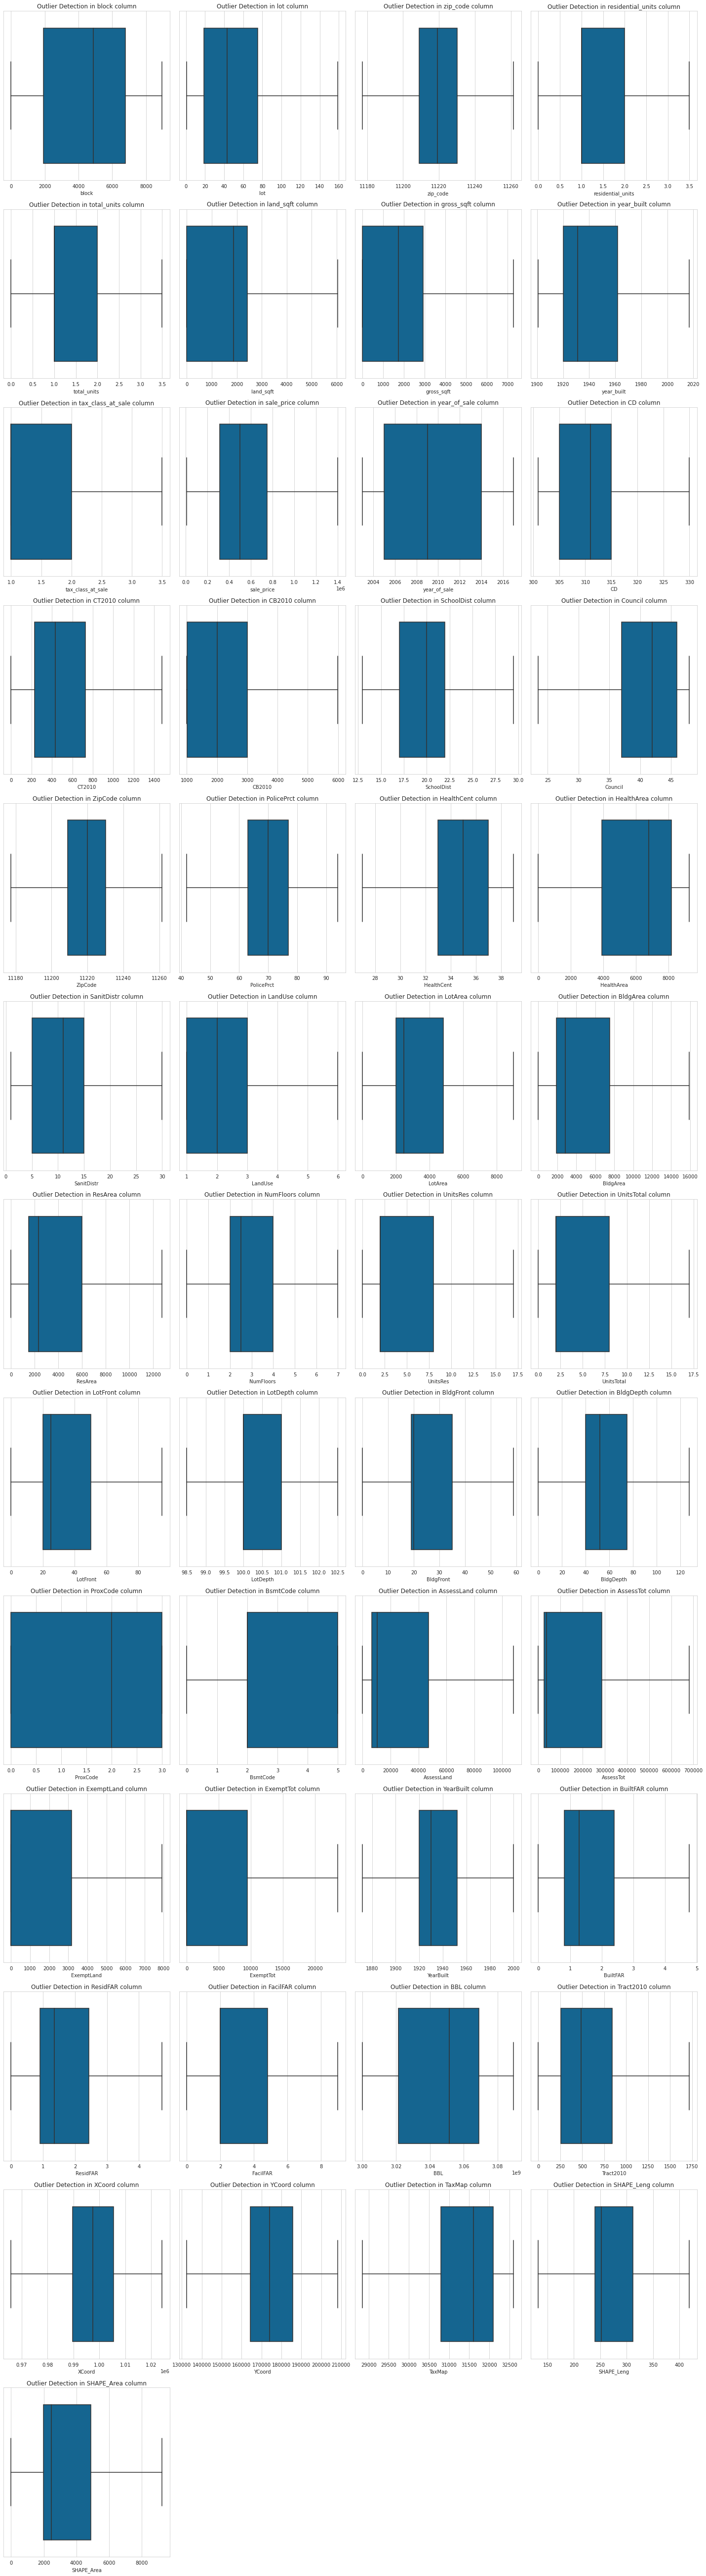

In [194]:
num_cols = df.select_dtypes('number').columns
k = 0
plt.figure(figsize=(20, 100))
for col in num_cols:
    plt.subplot(18, 4, k + 1)
    sns.boxplot(data=df, x=col)
    plt.xlabel(col)
    plt.title(f"Distribution of {col} column")
    k += 1
plt.tight_layout()

### Correlation Map

<AxesSubplot:>

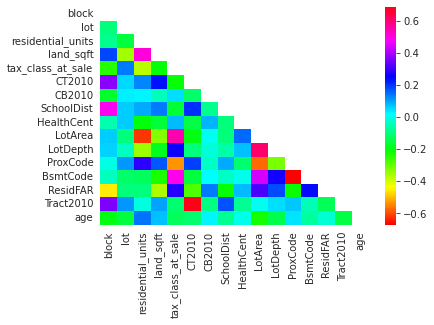

In [198]:
corr = df.drop('sale_price', axis=1).corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, cmap='hsv')

In [199]:
df.shape

(197492, 21)

In [200]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197492 entries, 1070 to 390880
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neighborhood            197492 non-null  object 
 1   block                   197492 non-null  float64
 2   lot                     197492 non-null  float64
 3   residential_units       197492 non-null  float64
 4   land_sqft               197492 non-null  float64
 5   tax_class_at_sale       197492 non-null  float64
 6   building_class_at_sale  197492 non-null  object 
 7   sale_price              197492 non-null  float64
 8   CT2010                  165726 non-null  float64
 9   CB2010                  165723 non-null  float64
 10  SchoolDist              165731 non-null  float64
 11  HealthCent              165740 non-null  float64
 12  SplitZone               165731 non-null  object 
 13  LotArea                 165740 non-null  float64
 14  LotDepth         

# Understanding Selected Features

<div style="background-color: #f2f2f2; border-radius: 10px; padding: 20px; margin: 20px; font-family: Arial, sans-serif;">
<p style="font-size: 20px; font-weight: bold;">Features:</p>
<p style="font-size: 14px;">
  1. <strong style="color: blue;">Neighborhood</strong> - NEIGHBORHOOD OF THE HOUSE<br>
  2. <strong style="color: blue;">Block</strong> - TAX BLOCK<br>
    &emsp;&emsp;The tax block in which the tax lot is located.<br>
  3. <strong style="color: blue;">Lot</strong> - TAX LOT<br>
    &emsp;&emsp;The number of the tax lot.<br>
  4. <strong style="color: blue;">Residential Units</strong> - RESIDENTIAL UNITS<br>
    &emsp;&emsp;The sum of residential units in all buildings on the tax lot.<br>
  5. <strong style="color: blue;">Tax Class at Sale</strong> - TAX CLASS OF HOUSE AT SALE<br>
  6. <strong style="color: blue;">Land Sqft</strong> - LAND AREA IN SQUARE FEET<br>
  7. <strong style="color: blue;">Building Class at Sale</strong> - BUILDING CLASS<br>
    &emsp;&emsp;A code describing the major use of structures on the tax lot.<br>
  8. <strong style="color: blue;">Sale Price</strong> - SALE PRICE OF THE HOUSE (Target)<br>
  9. <strong style="color: blue;">CT2010</strong> - CENSUS TRACT 2010<br>
    &emsp;&emsp;The 2010 census tract in which the tax lot is located.<br>
  10. <strong style="color: blue;">CB2010</strong> - CENSUS BLOCK 2010<br>
    &emsp;&emsp;The 2010 census block in which the tax lot is located.<br>
  11. <strong style="color: blue;">SchoolDist</strong> - SCHOOL DISTRICT<br>
    &emsp;&emsp;The school district in which the tax lot is located.<br>
  12. <strong style="color: blue;">HealthCent</strong> - HEALTH CENTER DISTRICT<br>
    &emsp;&emsp;The health center district in which the tax lot is located.<br>
  13. <strong style="color: blue;">SplitZone</strong> - SPLIT BOUNDARY INDICATOR<br>
    &emsp;&emsp;A code indicating whether the tax lot is split between multiple zoning features. The
        split boundary indicator is equal to “Y” if the tax lot has a value for ZONING
        DISTRICT 2, COMMERCIAL OVERLAY 2, or SPECIAL DISTRICT
        BOUNDARY 2. <br>
  14. <strong style="color: blue;">LotArea</strong> - LOT AREA<br>
    &emsp;&emsp;Total area of the tax lot, expressed in square feet rounded to the nearest integer. <br>
  15. <strong style="color: blue;">LotDepth</strong> - LOT DEPTH<br>
    &emsp;&emsp;The tax lot's depth measured in feet. <br>
  16. <strong style="color: blue;">ProxCode</strong> - PROXIMITY CODE<br>
    &emsp;&emsp;A code describing the physical relationship of the building to neighboring buildings.
    <ul style="margin: 30px"> 
        <li>0 - Not available</li>
        <li>1 - Detached</li>
        <li>2 - Semi-attached</li>
        <li>3 - Attached</li>
    </ul> <br>
  17. <strong style="color: blue;">IrrLotCode</strong> - IRREGULAR LOT CODE<br>
    &emsp;&emsp;A code indicating whether the tax lot is irregularly shaped.
    <ul style="margin: 30px"> 
        <li>Y - Yes, an irregularly shaped lot</li>
        <li>N - No, not an irregularly shaped lot</li>
    </ul> <br>
  18. <strong style="color: blue;">BsmtCode</strong> - BASEMENT TYPE/GRADE<br>
    &emsp;&emsp;A code describing the building’s basement.
    <ul style="margin: 30px"> 
        <li>0 - None/No Basement</li>
        <li>1 - Above grade full basement – the basement is 75% or more of the
                    area of the first floor and the basement walls are at least 4 feet high on
                    at least two sides</li>
        <li>2 - Below grade full basement – the basement is 75% or more of the
                    area of the first floor and the basement walls are fully submerged or
                    are less than 4 feet on at least three sides</li>
        <li>3 - Above grade partial basement – the basement is between 25% and
                    75% of the area of the first floor and the basement walls are at least 4
                    feet high on at least two sides</li>
        <li>4 - Below grade partial basement – the basement is between 25% and
                    75% of the area of the first floor and the basement walls are fully
                    submerged or are less than 4 feet on at least three sides</li>
        <li>5 - Unknown</li>
    </ul> 
   19. <strong style="color: blue;">ResidFAR</strong> - MAXIMUM ALLOWABLE RESIDENTIAL FAR<br>
    &emsp;&emsp;The maximum allowable residential floor area ratio<br>
  20. <strong style="color: blue;">CENSUS TRACT 2</strong> - CENSUS TRACT 2<br>
    &emsp;&emsp;The 2010 census tract in which the tax lot is located.<br>
  20. <strong style="color: blue;">age</strong> - AGE OF THE HOUSE<br>
    &emsp;&emsp;Calculated from the year built

## Dropping some more features

<div style="margin: 10px; padding: 15px; background-color: #f2f2f2; border-radius: 10px; font-style: italic;">
  <p>
    <span style="font-weight: bold;">💡 Eliminating Unnecessary Features:</span> With regards to our analysis, it's time to identify and eliminate features that won't add significant value.
  </p>
  <ul style="margin-left: 20px;">
    <li><span style="font-weight: bold;">Block & Lot:</span> These details won't add much value since we already have information about the neighborhood. Adding block & lot will only make the model unnecessarily complex.</li>
    <li><span style="font-weight: bold;">CB2010, Tract2010 & CT2010:</span> These are categorical variables that are associated with the location of the house and, thus, must be excluded.</li>
    <li><span style="font-weight: bold;">Health Cent & SchoolCent:</span> These are also categorical variables that are masked with numbers and associated with the location and, hence, can be removed.</li>
  </ul>
</div>

In [201]:
drop_cols = ['block', 'lot', 'CT2010', 'CB2010', 'HealthCent', 'SchoolDist', 'Tract2010']
df.drop(columns=drop_cols, axis=1, inplace=True)

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 197492 entries, 1070 to 390880
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neighborhood            197492 non-null  object 
 1   residential_units       197492 non-null  float64
 2   land_sqft               197492 non-null  float64
 3   tax_class_at_sale       197492 non-null  float64
 4   building_class_at_sale  197492 non-null  object 
 5   sale_price              197492 non-null  float64
 6   SplitZone               165731 non-null  object 
 7   LotArea                 165740 non-null  float64
 8   LotDepth                165740 non-null  float64
 9   ProxCode                165731 non-null  float64
 10  IrrLotCode              165731 non-null  object 
 11  BsmtCode                165731 non-null  float64
 12  ResidFAR                165740 non-null  float64
 13  age                     165740 non-null  float64
dtypes: float64(10), o

In [203]:
df.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165731 entries, 1070 to 390880
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neighborhood            165731 non-null  object 
 1   residential_units       165731 non-null  float64
 2   land_sqft               165731 non-null  float64
 3   tax_class_at_sale       165731 non-null  float64
 4   building_class_at_sale  165731 non-null  object 
 5   sale_price              165731 non-null  float64
 6   SplitZone               165731 non-null  object 
 7   LotArea                 165731 non-null  float64
 8   LotDepth                165731 non-null  float64
 9   ProxCode                165731 non-null  float64
 10  IrrLotCode              165731 non-null  object 
 11  BsmtCode                165731 non-null  float64
 12  ResidFAR                165731 non-null  float64
 13  age                     165731 non-null  float64
dtypes: float64(10), o

<div style="margin: 20px; padding: 20px; font-style: italic; background-color: #f2f2f2; border-radius: 10px;">
<p>📈 As we can observe, a substantial number of data points, almost 32,000, are missing values for certain features. This lack of information may cause a problem in training our model as these features will have similar values for most of the data points, if imputed. This, in turn, could lead to a poor generalization of the model. To prevent this, it's advisable to drop these data points and work with a reduced set of data.💼</p>
</div>

In [23]:
df.dropna(inplace=True)

In [24]:
df.shape

(166138, 14)

# Overall Wrangle Function

In [50]:
def treat_categorical(df):
    cat_cols = df.select_dtypes('object').columns
    k = 0
    cardinality_cols = []
    for col in cat_cols:
        value_counts = df[col].value_counts(normalize=True).round(2)
        if len(value_counts) > 5 or len(value_counts) < 2:
            cardinality_cols.append(col)
    return cardinality_cols

def get_low_variance_cols(df):
    num_cols = df.drop('sale_price', axis=1).select_dtypes('number').columns
    low_var_cols = []
    for col in num_cols:
        scaled = (df[col] - df[col].mean()) / df[col].std()
        variance = scaled.var().round(2)
        if variance == 0 or df[col].std() == 0:
            low_var_cols.append(col)
    return low_var_cols

def treat_na(df):
    req_cols = []
    for col in df.columns:
        is_na = round(df[col].isna().sum() / len(df) * 100, 2)
        if is_na < 50:
            req_cols.append(col)
    return req_cols

def wrangle(filepath):
    # Import data
    df = pd.read_csv(filepath, index_col=[0])
    print(f"Imported Data, Shape: {df.shape}")
    
    # Filter out the relevant data by sale_price and year_built
    mask = (df['year_built'] > 1900) & (df['sale_price'] > 100000) & (df['sale_price'] < 1e7)
    df = df[mask]
    print(f"Created mask, Shape: {df.shape}")
    
    # Remove features which have majority missing values
    req_cols = treat_na(df)
    df = df[req_cols]
    print(f"Filtered Columns by NaN, Shape: {df.shape}")
    
    # Remove high and low cardinality categorical columns
    drop_cols = treat_categorical(df)
    if 'neighborhood' in drop_cols:
        drop_cols.remove('neighborhood')
    if 'building_class_at_sale' in drop_cols:
        drop_cols.remove('building_class_at_sale')
    df.drop(columns=drop_cols, axis=1, inplace=True)
    print(f"Dropped Columns by Cardinality, Shape: {df.shape}")
    
    # Reduce the cardinality of neighborhood column
    neighborhood = df['neighborhood'].value_counts(normalize=True).round(2)
    idx = np.where(neighborhood > 0.01)[0].max()
    places = neighborhood.index[:idx]
    df['neighborhood'] =df['neighborhood'].apply(lambda x: x if x in places else 'OTHER')
    
    # Reduce the cardinality of building_class_at_sale column
    building_class = df['building_class_at_sale'].value_counts(normalize=True).round(2)
    idx = np.where(building_class > 0.01)[0].max()
    places = building_class.index[:idx]
    df['building_class_at_sale'] =df['building_class_at_sale'].apply(lambda x: x if x in places else 'OTHER')
    
    # Drop the columns with low variance
    low_var_cols = get_low_variance_cols(df)
    df.drop(columns=low_var_cols, axis=1, inplace=True)
    print(f"Dropped Columns by Variance, Shape: {df.shape}")
    
    # Calculate age of the house
    df['age'] = 2023 - (df['year_built'] + df['YearBuilt']) // 2
    
    # Drop unwanted columns
    drop = ['zip_code', 'ZipCode', 'year_built', 'YearBuilt', 'year_of_sale']
    df.drop(columns=drop, axis=1, inplace=True)
    print(f"Dropped Columns by redundancy, Shape: {df.shape}")
    
    # Drop columns with multicollinearity
    corr = df.drop('sale_price', axis=1).corr()
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    drop = [column for column in upper.columns if any(np.abs(upper[column]) > 0.7)]
    df.drop(columns=drop, axis=1, inplace=True)
    print(f"Dropped Columns by collinearity, Shape: {df.shape}")
    
    # Drop unwanted columns
    drop_cols = ['block', 'lot', 'CT2010', 'CB2010', 'HealthCent', 'SchoolDist', 'Tract2010']
    df.drop(columns=drop_cols, axis=1, inplace=True)
    print(f"Dropped Columns manually, Shape: {df.shape}")
    
    # Drop missing values
    df.dropna(inplace=True)
    print(f"Dropped NaN values, Shape: {df.shape}")
    
    return df

In [51]:
brooklyn = wrangle('/kaggle/input/brooklynhomes2003to2017/brooklyn_sales_map.csv')
print(brooklyn.shape)
brooklyn.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (40,41,43,45,46,47,86) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


Imported Data, Shape: (390883, 110)
Created mask, Shape: (189697, 110)
Filtered Columns by NaN, Shape: (189697, 90)
Dropped Columns by Cardinality, Shape: (189697, 75)
Dropped Columns by Variance, Shape: (189697, 53)
Dropped Columns by redundancy, Shape: (189697, 49)
Dropped Columns by collinearity, Shape: (189697, 21)
Dropped Columns manually, Shape: (189697, 14)
Dropped NaN values, Shape: (159145, 14)
(159145, 14)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:87: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


,neighborhood,residential_units,land_sqft,tax_class_at_sale,building_class_at_sale,sale_price,SplitZone,LotArea,LotDepth,ProxCode,IrrLotCode,BsmtCode,ResidFAR,age
1070,OTHER,0.0,6125.0,3.5,OTHER,9972000.0,N,7786.875,100.425,0.0,N,5.0,4.725,74.0
1072,OTHER,0.0,2454.0,3.5,OTHER,9950000.0,N,2454.000,99.745,0.0,N,2.0,0.000,20.0
1073,BEDFORD STUYVESANT,3.5,6125.0,3.5,OTHER,9936761.0,N,7786.875,100.425,0.0,N,1.0,2.000,93.0
1074,OCEAN HILL,0.0,6125.0,3.5,OTHER,9912766.0,N,7786.875,100.425,1.0,N,2.0,0.000,17.0
1075,FLATBUSH-EAST,3.5,6125.0,2.0,OTHER,9912000.0,N,7786.875,100.425,1.0,N,2.0,1.250,67.0


# Data Visualization

In [52]:
brooklyn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159145 entries, 1070 to 390880
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   neighborhood            159145 non-null  object 
 1   residential_units       159145 non-null  float64
 2   land_sqft               159145 non-null  float64
 3   tax_class_at_sale       159145 non-null  float64
 4   building_class_at_sale  159145 non-null  object 
 5   sale_price              159145 non-null  float64
 6   SplitZone               159145 non-null  object 
 7   LotArea                 159145 non-null  float64
 8   LotDepth                159145 non-null  float64
 9   ProxCode                159145 non-null  float64
 10  IrrLotCode              159145 non-null  object 
 11  BsmtCode                159145 non-null  float64
 12  ResidFAR                159145 non-null  float64
 13  age                     159145 non-null  float64
dtypes: float64(10), o

In [53]:
viz_df = brooklyn.copy()

In [54]:
median_home_price = viz_df['sale_price'].median().round(2)
median_home_price

500000.0

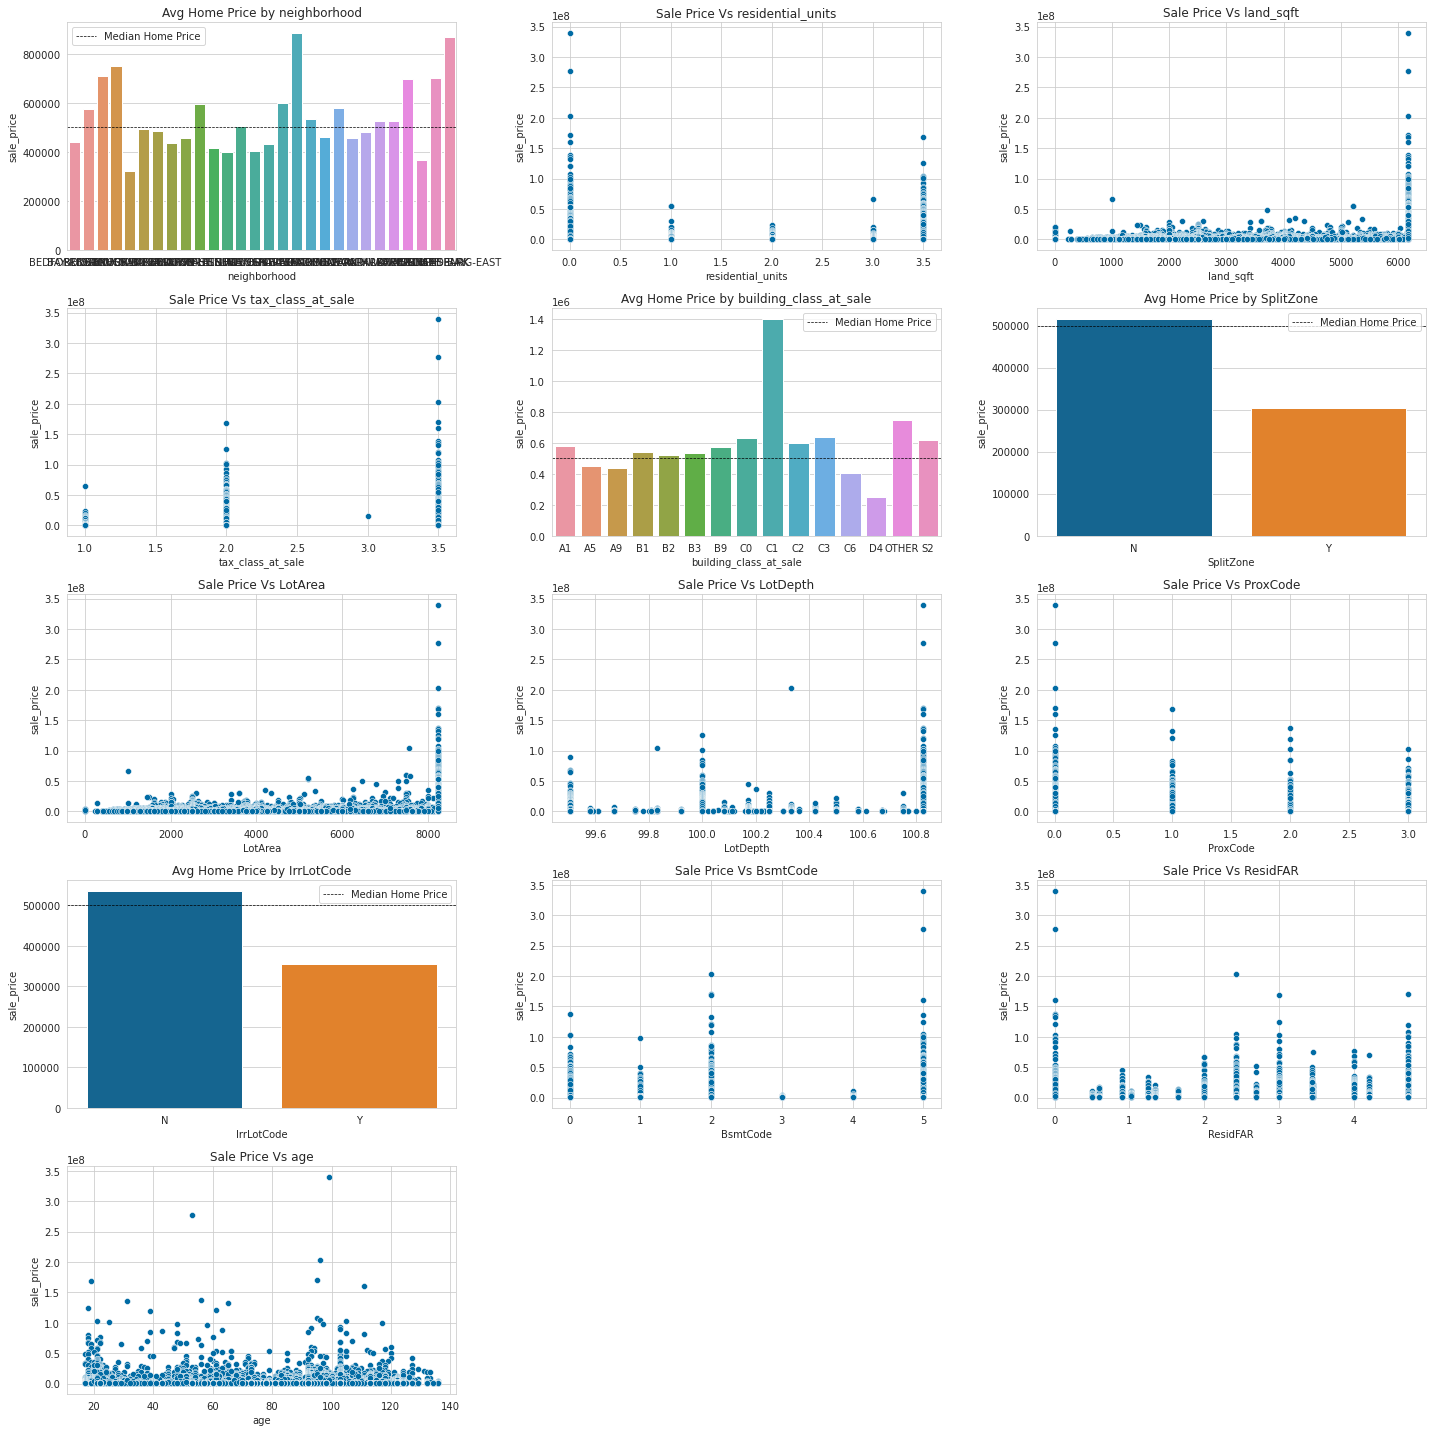

In [32]:
k = 0
plt.figure(figsize=(20, 20))
for col in viz_df.drop('sale_price', axis=1).columns:
    plt.subplot(5, 3, k + 1)
    if viz_df[col].dtype == 'float64':
        sns.scatterplot(data=viz_df, x=col, y='sale_price')
        plt.title(f"Sale Price Vs {col}")
    else:
        group = viz_df[[col, 'sale_price']].groupby(by=col).median()
        sns.barplot(data=group, x=group.index, y='sale_price')
        plt.axhline(y=median_home_price, label='Median Home Price', color='black', linestyle='--', linewidth=0.7)
        plt.title(f"Avg Home Price by {col}")
        plt.legend()
    k += 1
plt.tight_layout()

<div style="margin: 1em; padding: 1em; background-color: #f2f2f2; border-radius: 10px; font-style: italic;">
<p>🧐 It appears that the numerical columns don't have a strong linear correlation with the target column, making it challenging to predict the sale price using these columns alone. </p>
<p>💰 But, it seems that houses with regular lots tend to have a higher sale price compared to those with irregular lots. Similarly, houses not located in split zones tend to be more valuable. </p>
<p>🏠 Furthermore, house class C1 has a significantly higher sale price compared to other house classes. </p>
</div>

<AxesSubplot:xlabel='sale_price', ylabel='Count'>

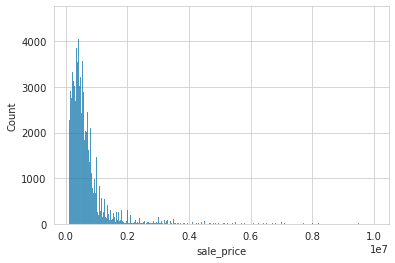

In [413]:
sns.histplot(viz_df['sale_price'])

<div style="margin: 1em; padding: 1em; background-color: #f2f2f2; border-radius: 10px; font-style: italic;">
<p style="font-size:16px; font-weight:bold;"> Normalizing the Target Column for Improved Model Performance</p>
<p style="font-size:14px;"> 
Unfortunately, the distribution of the target column, "sale_price," is not normal, which can negatively impact the performance of the model. To improve the training process, it's important to convert the distribution to a normal one. After thorough experimentation, I discovered that using a log transformation effectively converts the target column to an approximately normal distribution. 
</p>
</div>

<AxesSubplot:xlabel='sale_price', ylabel='Count'>

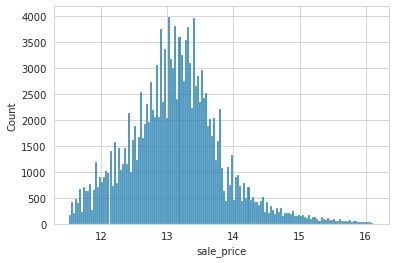

In [414]:
sns.histplot(np.log(viz_df['sale_price']))

# Training Machine Learning Models

In [55]:
X_train, X_test, y_train, y_test = train_test_split(brooklyn.drop('sale_price', axis=1), brooklyn['sale_price'], 
                                                    test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((127316, 13), (31829, 13), (127316,), (31829,))

## Baseline

In [56]:
y_mean = brooklyn['sale_price'].mean().round(2)
print("Baseline R2 Score:", r2_score(y_test, [y_mean] * len(y_test)).round(2))
print("Baseline Root Mean Squared Error:", mean_squared_error(y_test, [y_mean] * len(y_test), squared=False).round(2))

Baseline R2 Score: -0.0
Baseline Root Mean Squared Error: 792169.38


In [411]:
def train_model(model):
    model.fit(X_train, np.log(y_train))
    print(f"Train R-Squared: {r2_score(y_train, np.exp(model.predict(X_train))).round(2)}")
    print(f"Test R-Squared: {r2_score(y_test, np.exp(model.predict(X_test))).round(2)}")
    print(f"Train Root Mean Squared Error: {mean_squared_error(y_train, np.exp(model.predict(X_train)), squared=False).round(2)}")
    print(f"Test Root Mean Squared Error: {mean_squared_error(y_test, np.exp(model.predict(X_test)), squared=False).round(2)}")
    return model

## RandomForestRegressor

In [408]:
rf = make_pipeline(
    TargetEncoder(),
    RobustScaler(),
    RandomForestRegressor(random_state=42, n_jobs=-1)
)
rf = train_model(rf)

Train R-Squared: 0.78
Test R-Squared: 0.47
Train Root Mean Squared Error: 378110.6
Test Root Mean Squared Error: 575985.44


### Hyperparameter Tuning using Randomized SearchCV

In [214]:
params = {
    'randomforestregressor__n_estimators': np.arange(25, 126, 25),
    'randomforestregressor__min_samples_split': np.arange(2, 26, 5)
}
rf_grid = RandomizedSearchCV(
    estimator = rf,
    param_distributions=params,
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)
rf_grid = train_model(rf_grid)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Train R-Squared: 0.61
Test R-Squared: 0.49
Train Root Mean Squared Error: 504041.17
Test Root Mean Squared Error: 566316.19


In [216]:
rf_grid.best_estimator_

Pipeline(steps=[('targetencoder',
                 TargetEncoder(cols=['neighborhood', 'building_class_at_sale',
                                     'SplitZone', 'IrrLotCode'])),
                ('robustscaler', RobustScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(min_samples_split=22, n_jobs=-1,
                                       random_state=42))])

## XGBoost Regressor

In [409]:
xgb = make_pipeline(
    TargetEncoder(),
    RobustScaler(),
    XGBRegressor(random_state=42, n_jobs=-1),
)
xgb = train_model(xgb)

Train R-Squared: 0.53
Test R-Squared: 0.48
Train Root Mean Squared Error: 547767.39
Test Root Mean Squared Error: 569276.16


## CatBoost Regressor

In [410]:
cat = CatBoostRegressor(
    cat_features=list(X_train.select_dtypes('object').columns),
    verbose=0
)
cat = train_model(cat)

Train R-Squared: 0.51
Test R-Squared: 0.48
Train Root Mean Squared Error: 564020.53
Test Root Mean Squared Error: 569489.33


# Analyzing the Models 

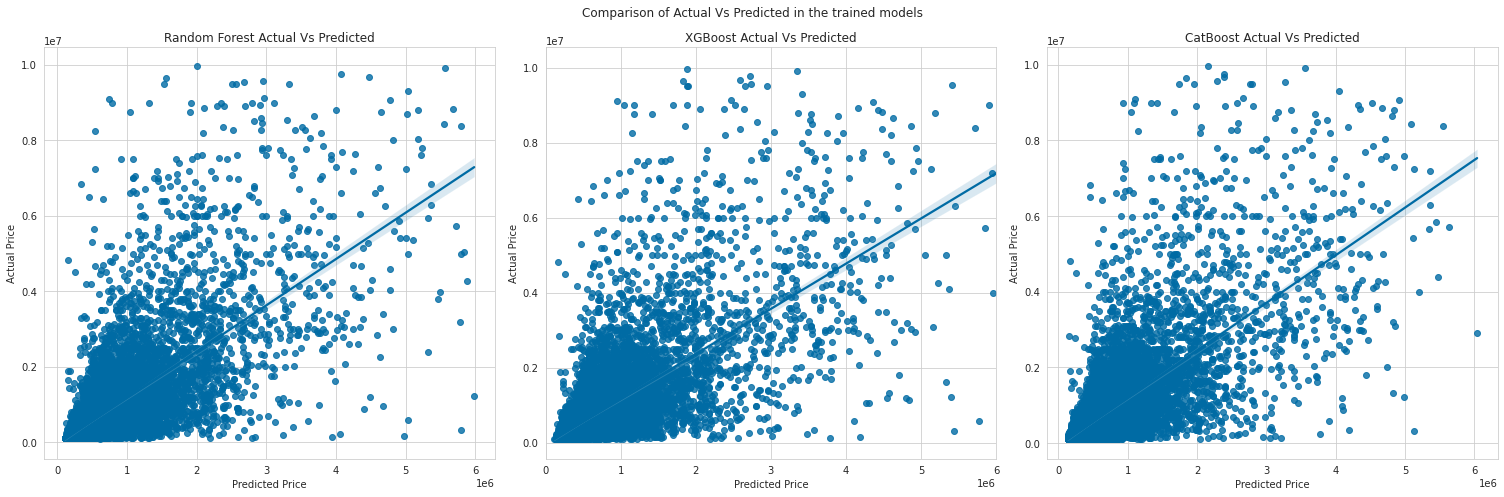

In [405]:
plt.figure(figsize=(21, 7))
plt.subplot(1, 3, 1)
preds = np.exp(rf_grid.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Random Forest Actual Vs Predicted');

plt.subplot(1, 3, 2)
preds = np.exp(xgb.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlim(0, 6e6)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('XGBoost Actual Vs Predicted');

plt.subplot(1, 3, 3)
preds = np.exp(cat.predict(X_test))
sns.regplot(x=preds, y=y_test)
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('CatBoost Actual Vs Predicted');

plt.suptitle('Comparison of Actual Vs Predicted in the trained models')
plt.tight_layout()

<p style="font-size: 18px; color: #444; font-weight: 500; background-color: #f2f2f2; padding: 20px; margin: 20px; border-radius:10px;">
  🔍 After a thorough analysis, it has become evident that all three models have produced <b style="color: #000;">similar results</b>. In particular, the XGBoost and CatBoost models have generated results with a very <b style="color: #000;">close RMSE</b>. But, tuned RandomForest has closer train and test RMSE. So, Random Forest Regressor is the best model in this situation.
</p>

## Feature Importances

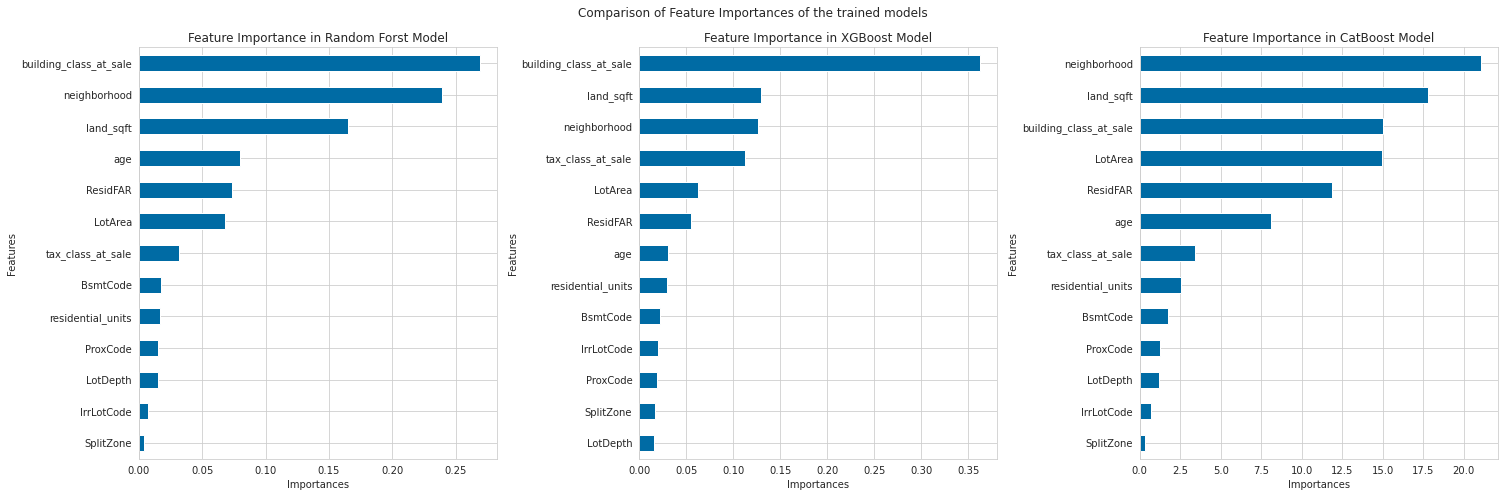

In [400]:
plt.figure(figsize=(21, 7))
feat_imp = rf_grid.best_estimator_.named_steps['randomforestregressor'].feature_importances_
rf_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 1)
rf_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forst Model');

feat_imp = xgb.named_steps['xgbregressor'].feature_importances_
xgb_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 2)
xgb_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in XGBoost Model');

feat_imp = cat.get_feature_importance()
cat_feat_imp = pd.Series(feat_imp, index=X_train.columns).sort_values()
plt.subplot(1, 3, 3)
cat_feat_imp.plot(kind='barh')
plt.xlabel('Importances')
plt.ylabel('Features')
plt.title('Feature Importance in CatBoost Model')

plt.suptitle('Comparison of Feature Importances of the trained models')
plt.tight_layout();

<div style="font-size:18px; font-weight: bold; margin: 1em; padding: 1em; background-color: #f2f2f2; border-radius: 10px;"> 💡Key Insights:
<div style="margin: 1em; padding: 1em; font-weight: normal;">
<p style="font-size:15px;">Our analysis has revealed that the most impactful features on the sale price of a house in Brooklyn are:</p>
<ul style="font-size:15px;">
    <li>Building class at sale</li>
    <li>Neighborhood</li>
    <li>Land square footage</li>
    <li>Age of the building</li>
    <li>Residential floor area ratio / lot area</li>
</ul> </div></div>
    <div style="font-size:18px; margin: 1em; padding: 1em; background-color: #f2f2f2; border-radius: 10px;">
<p style="font-size:15px;">👍 Keeping the neighborhood and building class at sale features in the model was a wise choice as it played a significant role in determining the sale price. Not reducing the cardinality of these features may have led to better scores, but would have come at the cost of increased complexity.</p></div>

# Model Inference

In [250]:
joblib.dump(rf_grid, 'randomforest.pkl', compress=9)
joblib.dump(xgb, 'xgboost.pkl', compress=9)
joblib.dump(cat, 'catboost.pkl', compress=9)

In [384]:
def predict_house_price(neighborhood, residential_units, land_sqft, tax_class_at_sale,
       building_class_at_sale, SplitZone, LotArea, LotDepth,
       ProxCode, IrrLotCode, BsmtCode, ResidFAR, age):
    
    params_dict = {
        'neighborhood': neighborhood,
        'residential_units': residential_units,
        'land_sqft': land_sqft,
        'tax_class_at_sale': tax_class_at_sale,
        'building_class_at_sale': building_class_at_sale,
        'SplitZone': SplitZone,
        'LotArea': LotArea,
        'LotDepth': LotDepth,
        'ProxCode': ProxCode,
        'IrrLotCode': IrrLotCode,
        'BsmtCode': BsmtCode,
        'ResidFAR': ResidFAR,
        'age': age
    }
    
    df = pd.DataFrame(params_dict, index=[0])
    
    with open('xgboost.pkl', 'rb') as f:
        xgb = joblib.load(f)
        
    xgb_pred = xgb.predict(df)
    
    avg = (np.exp(xgb_pred)).round(2)[0]
    
    return f"The Predicted House Price is ${avg}"

In [385]:
predict_house_price(
    neighborhood = "OTHER",
    residential_units = 2000, 
    land_sqft = 3060,
    tax_class_at_sale = 4,
    building_class_at_sale = 'OTHER',
    SplitZone = 'N',
    LotArea = 893832,
    LotDepth = 928,
    ProxCode = 4,
    IrrLotCode = 'Y',
    BsmtCode = 5,
    ResidFAR = 4,
    age = 110
)

'The Predicted House Price is $3427041.0'

# Conclusion

<div style="margin: 1em; padding: 1em; background-color: #BFBCFD; border-radius: 10px; font-style: italic;">
<p>After conducting a thorough analysis on the Brooklyn House dataset, we have a better understanding of the features that impact the sale price of a house. With the preprocessed and cleaned data, we trained a predictive model to estimate the sale price of a house in Brooklyn. This information can be valuable for real estate agents, investors and home buyers to make informed decisions.</p>
<p style="text-align: center;">💻 Let's create some accurate predictions! 💻</p>
</div>